In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

In [3]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/warning', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],


In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    print("left or right image not receieved")
    time.sleep(0.5)
    

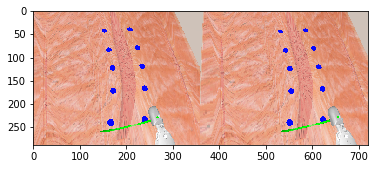

In [5]:
plt.imshow(np.hstack((left_image, right_image)))

In [6]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['ECM', 'simcamera', 'camera', 'PSM1', 'PSM2', 'PSM3', 'J1_PSM1', 'J1_PSM2']

In [7]:
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
ecm = dvrk.ecm('ECM')
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [9]:
# ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
# ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])
# ECM_STARTING_JOINT_POS = np.asarray([0, 0 ,  0.00261061,  0.043541  ])
ecm.move_joint(ECM_STARTING_JOINT_POS)

True

In [10]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

True

[ 0.0028     -0.019       0.06239207]
[      0.0028,      -0.019,   0.0623921]
[-0.01229167 -0.01833333  0.06499174]
[  -0.0122917,  -0.0183333,   0.0649917]
[ 0.00181818 -0.00613636  0.07090008]
[  0.00181818, -0.00613636,   0.0709001]
[-0.01428571 -0.0052381   0.07427627]
[  -0.0142857,  -0.0052381,   0.0742763]
[0.00238095 0.00547619 0.07427627]
[  0.00238095,  0.00547619,   0.0742763]
[-0.0135      0.0065      0.07799009]
[     -0.0135,      0.0065,   0.0779901]
[0.0045     0.01525    0.07799009]
[      0.0045,     0.01525,   0.0779901]
[-0.01157895  0.01736842  0.08209483]
[  -0.0115789,   0.0173684,   0.0820948]
[0.00710526 0.02710526 0.08209483]
[  0.00710526,   0.0271053,   0.0820948]
[-0.00823529  0.03088235  0.09175304]
[ -0.00823529,   0.0308824,    0.091753]


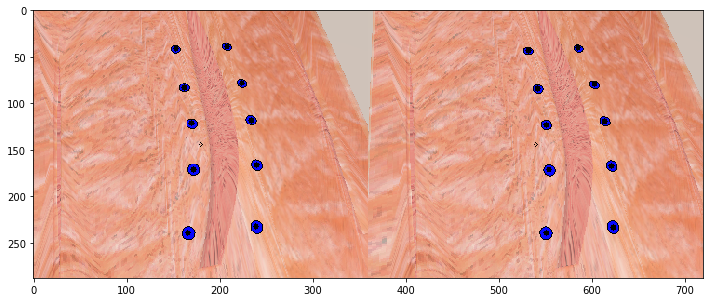

In [11]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.PSM_J1_TO_BASE_LINK_TF * utils.tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.PSM_J1_TO_BASE_LINK_TF * utils.tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z()-0.005)
#     o = PyKDL.Vector(o.x(), o.y(), o.z())

In [12]:
len(objects)

10

In [13]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
    pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
#     pt2 = min(objects, key=lambda obj : abs(obj.y() - pt.y()))
    objects.remove(pt2)
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
#     paired_pts.append(
#         (max(pt, pt2, key=lambda p: p.x()), min(pt, pt2, key=lambda p: p.x())))
print(paired_pts[0][0][1])
print(paired_pts[1][0][1])
paired_pts = sorted(paired_pts,key=lambda p: float(p[0][0]))
print("paired points sorted:")
paired_pts

-0.00450267146882
-0.00803435116815
paired points sorted:


[([    -1.58025, -0.00450267,    0.725648],
  [     -1.5809,  -0.0198116,    0.725223]),
 ([    -1.56541, -0.00803435,    0.723174],
  [     -1.5657,  -0.0244843,    0.722248]),
 ([    -1.55345, -0.00910652,    0.724695],
  [    -1.55346,  -0.0254034,    0.723488]),
 ([     -1.5428, -0.00853246,    0.724999],
  [    -1.54169,  -0.0251888,    0.723897]),
 ([    -1.53003,  -0.0077375,    0.725729],
  [    -1.52517,  -0.0247159,    0.720159])]

In [ ]:
import suturing_state_machine
reload(suturing_state_machine)
reload(utils)

sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, paired_pts[:3])  
sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, paired_pts[3:])

while not sm1.is_done() or not sm2.is_done():
    sm1.run_once()
    sm2.run_once()
    time.sleep(0.1)

[INFO] [1602406859.584942]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406859.593197]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406859.696642]: Distance from arm to dest: 0.0591980903332
[INFO] [1602406859.705290]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406859.715766]: Distance from arm to dest: 0.104031062277
[INFO] [1602406859.717601]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406859.828976]: Distance from arm to dest: 0.0560550415839
[INFO] [1602406859.839036]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406859.840907]: Distance from arm to dest: 0.0994830948498
[INFO] [1602406859.855217]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406859.960391]: Distance from arm to dest: 0.050031895254
[INFO] [1602406859.968827]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406859.970645]: Distance from arm to dest: 0.0920350653365
[INFO] [1602406859.979506]: Executing state 

[ERROR] [1602406859.981957]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7fbf2052add0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/parallels/dvrk_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



[INFO] [1602406860.224414]: Distance from arm to dest: 0.0284423172549
[INFO] [1602406860.234539]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406860.256333]: Distance from arm to dest: 0.0660196918824
[INFO] [1602406860.275374]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406860.384818]: Distance from arm to dest: 0.0149833933254
[INFO] [1602406860.387801]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406860.389397]: Distance from arm to dest: 0.0503824789397
[INFO] [1602406860.398734]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406860.507755]: Distance from arm to dest: 0.00749457655776
[INFO] [1602406860.509575]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406860.511107]: Distance from arm to dest: 0.0371250188644
[INFO] [1602406860.529795]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602406860.639099]: Distance from arm to dest: 0.00225569784745
[INFO] [1602406860.641017]: Executing state S

[INFO] [1602406862.149541]: Executing state SuturingState.INSERTION
[INFO] [1602406862.158890]: Moving to pose 9 out of 34
[INFO] [1602406862.161284]: Executing state SuturingState.INSERTION
[INFO] [1602406862.168497]: Moving to pose 8 out of 34
[INFO] [1602406862.270970]: Executing state SuturingState.INSERTION
[INFO] [1602406862.278389]: Moving to pose 10 out of 34
[INFO] [1602406862.280646]: Executing state SuturingState.INSERTION
[INFO] [1602406862.283433]: Moving to pose 9 out of 34
[INFO] [1602406862.391156]: Executing state SuturingState.INSERTION
[INFO] [1602406862.393056]: Moving to pose 11 out of 34
[INFO] [1602406862.402019]: Executing state SuturingState.INSERTION
[INFO] [1602406862.404069]: Moving to pose 10 out of 34
[INFO] [1602406862.512635]: Executing state SuturingState.INSERTION
[INFO] [1602406862.514931]: Moving to pose 12 out of 34
[INFO] [1602406862.522192]: Executing state SuturingState.INSERTION
[INFO] [1602406862.523811]: Moving to pose 11 out of 34
[INFO] [160

[INFO] [1602406866.478094]: Executing state SuturingState.INSERTION
[INFO] [1602406866.496921]: Moving to pose 32 out of 34
[INFO] [1602406866.499440]: Distance from arm to dest: 0.0274859603979
[INFO] [1602406866.508930]: Executing state SuturingState.OVERROTATE
circle_center=[    -1.55211,  -0.0184912,    0.739192], circle_radius=0.017
[INFO] [1602406866.619945]: Executing state SuturingState.INSERTION
[INFO] [1602406866.659822]: Moving to pose 32 out of 34
[INFO] [1602406866.669628]: Distance from arm to dest: 0.0215822330263
[INFO] [1602406866.675353]: Executing state SuturingState.OVERROTATE
circle_center=[    -1.55211,  -0.0184912,    0.739192], circle_radius=0.017
[INFO] [1602406866.790143]: Executing state SuturingState.INSERTION
[INFO] [1602406866.792909]: Moving to pose 32 out of 34
[INFO] [1602406866.802170]: Distance from arm to dest: 0.0172920356135
[INFO] [1602406866.811253]: Executing state SuturingState.OVERROTATE
circle_center=[    -1.55211,  -0.0184912,    0.739192], 

[INFO] [1602406869.773027]: Executing state SuturingState.INSERTION
[INFO] [1602406869.791988]: Moving to pose 32 out of 34
[INFO] [1602406869.793996]: Executing state SuturingState.EXTRACTION
[INFO] [1602406869.812405]: Moving to pose 13 out of 24
[INFO] [1602406869.935303]: Executing state SuturingState.INSERTION
[INFO] [1602406869.939948]: Moving to pose 32 out of 34
[INFO] [1602406869.950774]: Executing state SuturingState.EXTRACTION
[INFO] [1602406869.955264]: Moving to pose 14 out of 24
[INFO] [1602406870.057148]: Executing state SuturingState.INSERTION
[INFO] [1602406870.063826]: Moving to pose 32 out of 34
[INFO] [1602406870.066236]: Executing state SuturingState.EXTRACTION
[INFO] [1602406870.067996]: Moving to pose 15 out of 24
[INFO] [1602406870.176348]: Executing state SuturingState.INSERTION
[INFO] [1602406870.179087]: Moving to pose 32 out of 34
[INFO] [1602406870.187435]: Executing state SuturingState.EXTRACTION
[INFO] [1602406870.194022]: Moving to pose 16 out of 24
[INF

[INFO] [1602406874.309673]: Executing state SuturingState.INSERTION
[INFO] [1602406874.311714]: Moving to pose 32 out of 34
[INFO] [1602406874.323043]: Executing state SuturingState.HOME
[INFO] [1602406874.431700]: Executing state SuturingState.INSERTION
[INFO] [1602406874.441098]: Moving to pose 32 out of 34
[INFO] [1602406874.451554]: Executing state SuturingState.HOME
[INFO] [1602406874.558906]: Executing state SuturingState.INSERTION
[INFO] [1602406874.576053]: Moving to pose 32 out of 34
[INFO] [1602406874.585604]: Executing state SuturingState.HOME
[INFO] [1602406874.695968]: Executing state SuturingState.INSERTION
[INFO] [1602406874.706535]: Moving to pose 32 out of 34
[INFO] [1602406874.715599]: Executing state SuturingState.HOME
[INFO] [1602406874.824832]: Executing state SuturingState.INSERTION
[INFO] [1602406874.830195]: Moving to pose 32 out of 34
[INFO] [1602406874.845212]: Executing state SuturingState.HOME
[INFO] [1602406874.947376]: Executing state SuturingState.INSERTI

[INFO] [1602406877.251829]: Executing state SuturingState.INSERTION
[INFO] [1602406877.254573]: Moving to pose 32 out of 34
[INFO] [1602406877.261095]: Executing state SuturingState.INSERTION
[INFO] [1602406877.262745]: Moving to pose 6 out of 34
[INFO] [1602406877.364748]: Executing state SuturingState.INSERTION
[INFO] [1602406877.373184]: Moving to pose 32 out of 34
[INFO] [1602406877.374748]: Executing state SuturingState.INSERTION
[INFO] [1602406877.382193]: Moving to pose 7 out of 34
[INFO] [1602406877.484521]: Executing state SuturingState.INSERTION
[INFO] [1602406877.486132]: Moving to pose 32 out of 34
[INFO] [1602406877.495081]: Executing state SuturingState.INSERTION
[INFO] [1602406877.500122]: Moving to pose 8 out of 34
[INFO] [1602406877.603917]: Executing state SuturingState.INSERTION
[INFO] [1602406877.605616]: Moving to pose 32 out of 34
[INFO] [1602406877.607122]: Executing state SuturingState.INSERTION
[INFO] [1602406877.616558]: Moving to pose 9 out of 34
[INFO] [1602

[ERROR] [1602406878.312810]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fbf205139d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/parallels/dvrk_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



[INFO] [1602406878.445028]: Executing state SuturingState.INSERTION
[INFO] [1602406878.453498]: Moving to pose 32 out of 34
[INFO] [1602406878.455841]: Executing state SuturingState.INSERTION
[INFO] [1602406878.464694]: Moving to pose 16 out of 34
[INFO] [1602406878.566515]: Executing state SuturingState.INSERTION
[INFO] [1602406878.573954]: Moving to pose 32 out of 34
[INFO] [1602406878.576764]: Executing state SuturingState.INSERTION
[INFO] [1602406878.584027]: Moving to pose 17 out of 34
[INFO] [1602406878.687290]: Executing state SuturingState.INSERTION
[INFO] [1602406878.695867]: Moving to pose 32 out of 34
[INFO] [1602406878.698207]: Executing state SuturingState.INSERTION
[INFO] [1602406878.706969]: Moving to pose 18 out of 34
[INFO] [1602406878.809158]: Executing state SuturingState.INSERTION
[INFO] [1602406878.817277]: Moving to pose 32 out of 34
[INFO] [1602406878.818914]: Executing state SuturingState.INSERTION
[INFO] [1602406878.826016]: Moving to pose 19 out of 34
[INFO] [

[INFO] [1602406882.406527]: Executing state SuturingState.INSERTION
[INFO] [1602406882.408015]: Moving to pose 32 out of 34
[INFO] [1602406882.409426]: Distance from arm to dest: 0.0148937005987
[INFO] [1602406882.418552]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.53433,  -0.0204306,    0.729887], circle_radius=0.012
[INFO] [1602406882.529679]: Executing state SuturingState.INSERTION
[INFO] [1602406882.537513]: Moving to pose 32 out of 34
[INFO] [1602406882.540483]: Distance from arm to dest: 0.0146311258263
[INFO] [1602406882.550371]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.53433,  -0.0204306,    0.729887], circle_radius=0.012
[INFO] [1602406882.659688]: Executing state SuturingState.INSERTION
[INFO] [1602406882.661653]: Moving to pose 32 out of 34
[INFO] [1602406882.671134]: Distance from arm to dest: 0.0115869084506
[INFO] [1602406882.672588]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.53433,  -0

[INFO] [1602406885.690326]: Executing state SuturingState.INSERTION
[INFO] [1602406885.700130]: Moving to pose 32 out of 34
[INFO] [1602406885.711131]: Executing state SuturingState.EXTRACTION
[INFO] [1602406885.719739]: Moving to pose 19 out of 24
[INFO] [1602406885.822412]: Executing state SuturingState.INSERTION
[INFO] [1602406885.833132]: Moving to pose 32 out of 34
[INFO] [1602406885.842882]: Executing state SuturingState.EXTRACTION
[INFO] [1602406885.850888]: Moving to pose 20 out of 24
[INFO] [1602406885.954059]: Executing state SuturingState.INSERTION
[INFO] [1602406885.965144]: Moving to pose 32 out of 34
[INFO] [1602406885.979380]: Executing state SuturingState.EXTRACTION
[INFO] [1602406885.984601]: Moving to pose 21 out of 24
[INFO] [1602406886.093151]: Executing state SuturingState.INSERTION
[INFO] [1602406886.095364]: Moving to pose 32 out of 34
[INFO] [1602406886.103447]: Executing state SuturingState.EXTRACTION
[INFO] [1602406886.106083]: Moving to pose 22 out of 24
[INF

[INFO] [1602406890.990194]: Executing state SuturingState.INSERTION
[INFO] [1602406890.992056]: Moving to pose 32 out of 34
[INFO] [1602406891.100820]: Executing state SuturingState.INSERTION
[INFO] [1602406891.103214]: Moving to pose 32 out of 34
[INFO] [1602406891.213711]: Executing state SuturingState.INSERTION
[INFO] [1602406891.234410]: Moving to pose 32 out of 34
[INFO] [1602406891.352708]: Executing state SuturingState.INSERTION
[INFO] [1602406891.355851]: Moving to pose 32 out of 34
[INFO] [1602406891.468097]: Executing state SuturingState.INSERTION
[INFO] [1602406891.477216]: Moving to pose 32 out of 34
[INFO] [1602406891.594323]: Executing state SuturingState.INSERTION
[INFO] [1602406891.596401]: Moving to pose 32 out of 34
[INFO] [1602406891.698515]: Executing state SuturingState.INSERTION
[INFO] [1602406891.707397]: Moving to pose 32 out of 34
[INFO] [1602406891.809423]: Executing state SuturingState.INSERTION
[INFO] [1602406891.818934]: Moving to pose 32 out of 34
[INFO] [

[INFO] [1602406899.114927]: Executing state SuturingState.INSERTION
[INFO] [1602406899.123263]: Moving to pose 32 out of 34
[INFO] [1602406899.225060]: Executing state SuturingState.INSERTION
[INFO] [1602406899.231765]: Moving to pose 32 out of 34
[INFO] [1602406899.337374]: Executing state SuturingState.INSERTION
[INFO] [1602406899.348057]: Moving to pose 32 out of 34
[INFO] [1602406899.464896]: Executing state SuturingState.INSERTION
[INFO] [1602406899.469433]: Moving to pose 32 out of 34
[INFO] [1602406899.589130]: Executing state SuturingState.INSERTION
[INFO] [1602406899.598205]: Moving to pose 32 out of 34
[INFO] [1602406899.701582]: Executing state SuturingState.INSERTION
[INFO] [1602406899.709723]: Moving to pose 32 out of 34
[INFO] [1602406899.811641]: Executing state SuturingState.INSERTION
[INFO] [1602406899.813579]: Moving to pose 32 out of 34
[INFO] [1602406899.923565]: Executing state SuturingState.INSERTION
[INFO] [1602406899.944174]: Moving to pose 32 out of 34
[INFO] [

[INFO] [1602406906.893909]: Executing state SuturingState.INSERTION
[INFO] [1602406906.897277]: Moving to pose 32 out of 34
[INFO] [1602406907.008064]: Executing state SuturingState.INSERTION
[INFO] [1602406907.014933]: Moving to pose 32 out of 34
[INFO] [1602406907.117695]: Executing state SuturingState.INSERTION
[INFO] [1602406907.119941]: Moving to pose 32 out of 34
[INFO] [1602406907.228066]: Executing state SuturingState.INSERTION
[INFO] [1602406907.229795]: Moving to pose 32 out of 34
[INFO] [1602406907.331462]: Executing state SuturingState.INSERTION
[INFO] [1602406907.340430]: Moving to pose 32 out of 34
[INFO] [1602406907.443286]: Executing state SuturingState.INSERTION
[INFO] [1602406907.449777]: Moving to pose 32 out of 34
[INFO] [1602406907.551717]: Executing state SuturingState.INSERTION
[INFO] [1602406907.553792]: Moving to pose 32 out of 34
[INFO] [1602406907.669159]: Executing state SuturingState.INSERTION
[INFO] [1602406907.673386]: Moving to pose 32 out of 34
[INFO] [

[INFO] [1602406914.391140]: Executing state SuturingState.INSERTION
[INFO] [1602406914.393521]: Moving to pose 32 out of 34
[INFO] [1602406914.495133]: Executing state SuturingState.INSERTION
[INFO] [1602406914.498400]: Moving to pose 32 out of 34
[INFO] [1602406914.602965]: Executing state SuturingState.INSERTION
[INFO] [1602406914.604896]: Moving to pose 32 out of 34
[INFO] [1602406914.706650]: Executing state SuturingState.INSERTION
[INFO] [1602406914.708665]: Moving to pose 32 out of 34
[INFO] [1602406914.816402]: Executing state SuturingState.INSERTION
[INFO] [1602406914.819498]: Moving to pose 32 out of 34
[INFO] [1602406914.927793]: Executing state SuturingState.INSERTION
[INFO] [1602406914.929869]: Moving to pose 32 out of 34
[INFO] [1602406915.037888]: Executing state SuturingState.INSERTION
[INFO] [1602406915.039644]: Moving to pose 32 out of 34
[INFO] [1602406915.142116]: Executing state SuturingState.INSERTION
[INFO] [1602406915.148092]: Moving to pose 32 out of 34
[INFO] [

In [ ]:
dir(psm1)

In [ ]:
ecm.get_current_joint_position()

In [ ]:
psm2.close_jaw()